# Loan Application MLP model

We saw earlier that a single hidden layer MLP model was over-fitting the data.

Let us use different over-fitting techniques to address this issue.

## Data Preparation and Pre-processing

In [10]:
import pandas as pd

In [11]:
train_ds = pd.read_excel("Loan_Application.xlsx")

train_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1570 entries, 0 to 1569
Data columns (total 38 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            1570 non-null   int64  
 1   Decision      1570 non-null   int64  
 2   Selfcon_Code  1570 non-null   int64  
 3   Tier_1        1570 non-null   int64  
 4   Tier_2        1570 non-null   int64  
 5   AccoClass     1570 non-null   int64  
 6   LoanType      1570 non-null   int64  
 7   Gender        1570 non-null   int64  
 8   Etype         1570 non-null   int64  
 9   Doc_pf        1570 non-null   int64  
 10  Marstat       1570 non-null   int64  
 11  Emp_Type_1    1570 non-null   int64  
 12  Emp_Type_2    1570 non-null   int64  
 13  Emp_Type_3    1570 non-null   int64  
 14  Educlass_2    1570 non-null   int64  
 15  Educlass_1    1570 non-null   int64  
 16  Oriclass_1    1570 non-null   int64  
 17  Oriclass_2    1570 non-null   int64  
 18  eom_25        1570 non-null 

In [12]:
train_ds.columns

Index(['ID', 'Decision', 'Selfcon_Code', 'Tier_1', 'Tier_2', 'AccoClass',
       'LoanType', 'Gender', 'Etype', 'Doc_pf', 'Marstat', 'Emp_Type_1',
       'Emp_Type_2', 'Emp_Type_3', 'Educlass_2', 'Educlass_1', 'Oriclass_1',
       'Oriclass_2', 'eom_25', 'OldEmi_d', 'BankSave_d', 'Age', 'YrsAdd',
       'YrsJob', 'DispInc', 'MarVal', 'OldEmi', 'LoanReq', 'Term', 'Dwnpay',
       'BankSave', 'CalcEmi', 'IIR', 'IAR', 'FOIR', 'LTV', 'LVR',
       'dwnp_prop_p'],
      dtype='object')

In [13]:
# Setting up Independent and Dependent Variable

X = train_ds.iloc[:, 2:]
y = train_ds.iloc[:, 1]

In [14]:
num_inputs = X.shape[1]

In [15]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 0)


In [16]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)

## Model Building - Grid Search using Scikit-learn

In the previous session, we directly entered the hyper-parameter values without fiddling with it. Generally, we would have to fiddle with multiple values manually to finally decide a good combination of hyper-parameter values. But, this is quite a laborious and time-consuming task and hence most of the time impractical.

Instead, we could use Scikit-Learn's Grid Search. We just have to mention the various values of the hyper-parameters we would want to explore and Grid Search would evaluate all possible combinations of the values using cross-validation.

First, let us build the model architecture and define the various hyper-parameters we would be using.

In [17]:
# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2,l1

# Function to build a Keras Model
def build_classifier(hidden_layers = [50], dropout_rate = 0.3,
                     regularization_type = l1, regularization_factor = 0.1, 
                     optimizer = 'adam', num_inputs = 36):
 
  model = Sequential()   # Initialize the Sequential API
  for layers in hidden_layers:   
    model.add(Dense(units = layers, input_dim = num_inputs, activation="relu", 
                    kernel_regularizer = regularization_type(regularization_factor)))
    model.add(BatchNormalization())
    model.add(Dropout(rate = dropout_rate))

  model.add(Dense(activation="sigmoid", units=1))
  
  model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

  return model

In [19]:
from scikeras.wrappers import KerasClassifier, KerasRegressor

classifier = KerasClassifier(
    build_fn = build_classifier, num_inputs = num_inputs, batch_size = 100)

Now, that we have defined the model architecture, let us create a dictionary of hyper-parameters and various values we would want to pass for evaluation. 

The parameters dictionary indicates that Grid Search has 2 ^ 4 = 16 combinations of regularization_type, regularization_factor, dropout_rate and optimizer to explore and find for the best combination.

In [29]:
parameters = {'model__regularization_type' : [l1, l2],
              'model__regularization_factor' : [0.01, 0.1],
              'model__dropout_rate' : [0.3, 0.5],          
              'model__optimizer': ['adam', 'sgd']}

Let us import GridSearchCV and pass the estimator, parameter dictionary, scoring metric for evaluation and number of cross validation folds.

Since we have set the CV parameter to 10, we would be performing around 16 * 10 = 160 rounds of training per epoch. This means that is quite time consuming, and if we add additional parameter or value in the dictionary and increase the epochs, the rounds increase quite a lot of times. 

Hence GridSearchCV is preferable only when we have just few combinations and when the hyper-parameter search space is large, we tend to use RansomizedSearchCV. The difference being that instead of searching all the combinations, it evaluates a given number of random combinations by selecting random value for each hyperparmeter at every iteration.

Besides that, it is advisable to spare a thought on choosing the hyper-parameter based on the understanding of the concepts. For instance, when we observed the over-fitting earlier, we saw that it occurred quite early i.e. after first few epochs itself. We also know that one of the reasons for over-fitting, could be that the model is too complex for the dataset or has many variables than required. So, we can either do feature selection, which is quite difficult to do or use regularization technique such as l1 regularization, which can reduce the weights to zero and perform feature selection implicitly.

So, let us validate our understanding by passing on both l1 and l2 and see whether the grid search gives the best parameter as l1 or not.



In [30]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)

In [33]:
grid_search = grid_search.fit(X_train, y_train, epochs=10)

/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4892 - loss: 3.4172
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5426 - loss: 3.1533
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5759 - loss: 2.8938
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6100 - loss: 2.6658
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6416 - loss: 2.4844
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6313 - loss: 2.3269
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7124 - loss: 2.1415
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7632 - loss: 1.9557
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7361 - loss: 1.8467
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7430 - loss: 1.7271
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4827 - loss: 3.1988
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5110 - loss: 2.9758
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5372 - loss: 2.7666
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6205 - loss: 2.5046
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6517 - loss: 2.3378
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6903 - loss: 2.1575
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6965 - loss: 2.0143
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7232 - loss: 1.8867
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7282 - loss: 1.7291
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7389 - loss: 1.6076
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5340 - loss: 3.2463
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5777 - loss: 2.9693
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6024 - loss: 2.7914
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6447 - loss: 2.5684
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6667 - loss: 2.4142
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7203 - loss: 2.2198
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7123 - loss: 2.0951
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7261 - loss: 1.9586
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7595 - loss: 1.7951
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7338 - loss: 1.6963
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5153 - loss: 3.3264
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5460 - loss: 3.0644
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5834 - loss: 2.8403
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6376 - loss: 2.6209
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6872 - loss: 2.4619
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7076 - loss: 2.2890
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7092 - loss: 2.1319
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7146 - loss: 2.0056
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7321 - loss: 1.8729
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7435 - loss: 1.7445
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5237 - loss: 3.3887
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5509 - loss: 3.0968
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5747 - loss: 2.8734
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6152 - loss: 2.6450
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6487 - loss: 2.4622
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6837 - loss: 2.2951
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6898 - loss: 2.1351
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7107 - loss: 1.9890
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7468 - loss: 1.8245
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7655 - loss: 1.7059
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4908 - loss: 3.2294
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5527 - loss: 2.9818
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6167 - loss: 2.7649
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6318 - loss: 2.5636
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6598 - loss: 2.3474
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6744 - loss: 2.1968
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7246 - loss: 2.0260
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7251 - loss: 1.8895
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7327 - loss: 1.7583
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7552 - loss: 1.6110
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5294 - loss: 3.2688
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5723 - loss: 3.0049
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6025 - loss: 2.8009
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6559 - loss: 2.6089
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6646 - loss: 2.4325
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6958 - loss: 2.2550
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7179 - loss: 2.0849
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7075 - loss: 1.9690
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7142 - loss: 1.8390
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7711 - loss: 1.6771
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4808 - loss: 3.5713
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5190 - loss: 3.1958
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5322 - loss: 2.9813
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6008 - loss: 2.6713
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6334 - loss: 2.4939
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6807 - loss: 2.3055
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6671 - loss: 2.1610
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6917 - loss: 2.0000
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7156 - loss: 1.8525
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7498 - loss: 1.7394
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.4654 - loss: 3.3594
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5042 - loss: 3.0915
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5594 - loss: 2.8479
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5548 - loss: 2.6804
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6517 - loss: 2.4336
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6812 - loss: 2.2686
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6890 - loss: 2.1115
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7169 - loss: 1.9626
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7188 - loss: 1.8204
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7459 - loss: 1.6925
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.5211 - loss: 3.1572
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5744 - loss: 2.8877
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6199 - loss: 2.7056
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6550 - loss: 2.4978
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6812 - loss: 2.3059
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6628 - loss: 2.1875
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7109 - loss: 2.0105
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7161 - loss: 1.8655
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7334 - loss: 1.7332
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7591 - loss: 1.5789
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5316 - loss: 1.2569
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5832 - loss: 1.1356
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6201 - loss: 1.0397
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6856 - loss: 0.9412
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6871 - loss: 0.9237
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7274 - loss: 0.8488
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7297 - loss: 0.8309
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7446 - loss: 0.7933
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7866 - loss: 0.7414
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7689 - loss: 0.7264
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5178 - loss: 1.2744
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5275 - loss: 1.1911
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5940 - loss: 1.0745
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6347 - loss: 1.0000
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6892 - loss: 0.9252
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6792 - loss: 0.8976
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7190 - loss: 0.8385
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7329 - loss: 0.7853
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7495 - loss: 0.7607
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7754 - loss: 0.7266
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4640 - loss: 1.3935
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5303 - loss: 1.2217
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6086 - loss: 1.0779
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6586 - loss: 1.0034
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6730 - loss: 0.9514
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6904 - loss: 0.8861
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7233 - loss: 0.8280
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7356 - loss: 0.8015
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7589 - loss: 0.7760
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7527 - loss: 0.7672
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4664 - loss: 1.4054
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5129 - loss: 1.2110
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5960 - loss: 1.0671
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6870 - loss: 0.9660
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6854 - loss: 0.9334
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7182 - loss: 0.8715
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7412 - loss: 0.8381
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7533 - loss: 0.8219
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7688 - loss: 0.7364
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7777 - loss: 0.7398
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.4822 - loss: 1.3392
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5582 - loss: 1.1835
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6106 - loss: 1.0804
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6595 - loss: 0.9894
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6868 - loss: 0.9270
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6823 - loss: 0.8759
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7437 - loss: 0.8314
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7529 - loss: 0.7967
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7469 - loss: 0.7869
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7675 - loss: 0.7351
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5043 - loss: 1.3761
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5501 - loss: 1.2140
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6033 - loss: 1.0926
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6227 - loss: 1.0187
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6573 - loss: 0.9661
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6901 - loss: 0.9183
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7019 - loss: 0.8701
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7147 - loss: 0.8514
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7364 - loss: 0.7953
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7488 - loss: 0.7618
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5061 - loss: 1.3475
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5631 - loss: 1.1835
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6129 - loss: 1.0900
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6220 - loss: 0.9930
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6937 - loss: 0.9146
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6942 - loss: 0.8805
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7281 - loss: 0.8264
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7369 - loss: 0.7900
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7622 - loss: 0.7405
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7592 - loss: 0.7470
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4744 - loss: 1.3936
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5308 - loss: 1.2152
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5335 - loss: 1.1362
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6096 - loss: 1.0291
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6702 - loss: 0.9495
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7030 - loss: 0.8938
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7202 - loss: 0.8688
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7209 - loss: 0.8113
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7504 - loss: 0.7892
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7679 - loss: 0.7505
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.4522 - loss: 1.3682
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5622 - loss: 1.1784
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6003 - loss: 1.0820
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6608 - loss: 0.9549
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6808 - loss: 0.9110
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6783 - loss: 0.8954
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7322 - loss: 0.8298
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7425 - loss: 0.7908
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7510 - loss: 0.7545
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7682 - loss: 0.7341
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5156 - loss: 1.3544
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5900 - loss: 1.1599
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6116 - loss: 1.0814
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6596 - loss: 0.9957
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6821 - loss: 0.9256
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7008 - loss: 0.9094
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7228 - loss: 0.8434
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7527 - loss: 0.7979
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7434 - loss: 0.7828
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7619 - loss: 0.7553
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.4887 - loss: 23.9572
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5176 - loss: 21.8323
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5476 - loss: 19.8074
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5814 - loss: 17.8862
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5847 - loss: 16.1057
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6312 - loss: 14.3901
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6380 - loss: 12.7970
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6737 - loss: 11.3229
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6934 - loss: 9.8903
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7217 - loss: 8.6248
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5473 - loss: 23.8040
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5405 - loss: 21.7586
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5845 - loss: 19.7094
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5851 - loss: 17.8489
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6219 - loss: 16.0301
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6343 - loss: 14.3522
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6735 - loss: 12.7289
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6994 - loss: 11.2418
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6958 - loss: 9.8472
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7168 - loss: 8.5442
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.4916 - loss: 24.2742
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5493 - loss: 22.1110
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5315 - loss: 20.1158
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5547 - loss: 18.1961
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5998 - loss: 16.3266
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6373 - loss: 14.5927
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6332 - loss: 13.0050
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6730 - loss: 11.4735
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6676 - loss: 10.0769
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6707 - loss: 8.7670
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.4716 - loss: 24.8672
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4971 - loss: 22.7438
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4955 - loss: 20.6952
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5079 - loss: 18.7603
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5394 - loss: 16.8833
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5826 - loss: 15.1074
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6367 - loss: 13.3777
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6497 - loss: 11.8150
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6860 - loss: 10.3397
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6901 - loss: 9.0032
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.5062 - loss: 24.0997
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5172 - loss: 21.9754
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5892 - loss: 19.8972
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6122 - loss: 17.9705
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6233 - loss: 16.1500
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6526 - loss: 14.3813
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6474 - loss: 12.7904
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6822 - loss: 11.2374
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7034 - loss: 9.8186
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7020 - loss: 8.5478
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.5027 - loss: 24.7505
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5064 - loss: 22.5946
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5310 - loss: 20.5384
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5546 - loss: 18.5893
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5915 - loss: 16.7388
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6347 - loss: 15.0181
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6208 - loss: 13.4223
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6507 - loss: 11.8444
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6837 - loss: 10.4054
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7198 - loss: 9.0498
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.5016 - loss: 23.8700
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5388 - loss: 21.7528
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5643 - loss: 19.7432
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5750 - loss: 17.7922
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6094 - loss: 15.9398
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6403 - loss: 14.2250
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6506 - loss: 12.6196
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6784 - loss: 11.1042
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7069 - loss: 9.7177
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7259 - loss: 8.4157
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.4536 - loss: 24.1943
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4997 - loss: 22.0727
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4876 - loss: 20.0574
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5518 - loss: 18.0844
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5393 - loss: 16.3199
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5932 - loss: 14.5777
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6425 - loss: 12.9510
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6389 - loss: 11.4597
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6552 - loss: 10.0612
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6774 - loss: 8.7159
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5150 - loss: 23.4193
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5210 - loss: 21.2920
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5916 - loss: 19.2710
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5914 - loss: 17.4074
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6412 - loss: 15.6315
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6232 - loss: 13.9589
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6743 - loss: 12.3614
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6689 - loss: 10.9265
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6935 - loss: 9.5417
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7176 - loss: 8.2706
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.4787 - loss: 24.6089
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5557 - loss: 22.4412
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5411 - loss: 20.4716
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5751 - loss: 18.5166
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5793 - loss: 16.6757
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5992 - loss: 14.9263
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6703 - loss: 13.2255
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6744 - loss: 11.6875
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6775 - loss: 10.2544
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7133 - loss: 8.9285
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.4658 - loss: 5.1489
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5172 - loss: 4.5331
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5473 - loss: 3.9529
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5654 - loss: 3.4755
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5938 - loss: 3.0777
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6478 - loss: 2.7039
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6450 - loss: 2.4358
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6990 - loss: 2.1330
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7173 - loss: 1.8997
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7410 - loss: 1.6935
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5210 - loss: 4.9052
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5415 - loss: 4.3443
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5988 - loss: 3.8144
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6182 - loss: 3.3781
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6324 - loss: 2.9825
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6786 - loss: 2.6269
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7079 - loss: 2.3281
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7306 - loss: 2.0718
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7520 - loss: 1.8289
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7638 - loss: 1.6351
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5058 - loss: 4.8062
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5347 - loss: 4.2253
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5476 - loss: 3.7395
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6044 - loss: 3.2997
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6952 - loss: 2.8907
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6846 - loss: 2.5608
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7072 - loss: 2.2708
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7088 - loss: 2.0372
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7565 - loss: 1.7927
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7617 - loss: 1.6011
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.5083 - loss: 5.0098
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5696 - loss: 4.3884
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5892 - loss: 3.8148
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6159 - loss: 3.4100
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6031 - loss: 3.0460
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6965 - loss: 2.6371
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6865 - loss: 2.3668
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.7191 - loss: 2.0579
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7372 - loss: 1.8402
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7125 - loss: 1.6585
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.5438 - loss: 4.8862
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5491 - loss: 4.3996
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6093 - loss: 3.8285
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6132 - loss: 3.4143
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6550 - loss: 3.0117
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6453 - loss: 2.6826
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7047 - loss: 2.3937
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7193 - loss: 2.1005
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7367 - loss: 1.8987
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7425 - loss: 1.6821
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.4858 - loss: 5.2250
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5316 - loss: 4.5667
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5353 - loss: 4.0671
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5597 - loss: 3.5712
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6070 - loss: 3.1546
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6496 - loss: 2.7925
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7003 - loss: 2.4412
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7252 - loss: 2.1647
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7496 - loss: 1.9251
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7284 - loss: 1.7372
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5568 - loss: 4.7875
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5957 - loss: 4.2228
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6641 - loss: 3.6690
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6326 - loss: 3.2665
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6686 - loss: 2.8825
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7159 - loss: 2.5375
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7036 - loss: 2.2940
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7395 - loss: 2.0386
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7657 - loss: 1.7842
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7680 - loss: 1.6013
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.4950 - loss: 4.8266
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4951 - loss: 4.2960
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5661 - loss: 3.7499
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6122 - loss: 3.3080
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6189 - loss: 2.9833
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6899 - loss: 2.5789
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6875 - loss: 2.3251
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7216 - loss: 2.0511
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7047 - loss: 1.8524
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7668 - loss: 1.6204
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.4970 - loss: 5.0861
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5326 - loss: 4.4826
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5670 - loss: 3.9812
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5982 - loss: 3.4876
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6301 - loss: 3.1154
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6684 - loss: 2.7477
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6809 - loss: 2.4331
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6913 - loss: 2.1726
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7276 - loss: 1.9162
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7651 - loss: 1.7002
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5480 - loss: 4.8159
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5896 - loss: 4.2398
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6125 - loss: 3.7694
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6295 - loss: 3.3390
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6619 - loss: 2.9344
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6833 - loss: 2.6064
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7322 - loss: 2.3047
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7344 - loss: 2.0514
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7459 - loss: 1.8290
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7780 - loss: 1.6212
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.5592 - loss: 3.2230
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5681 - loss: 3.1436
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5665 - loss: 3.1069
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6037 - loss: 3.0724
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6286 - loss: 3.0082
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6571 - loss: 2.9519
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6761 - loss: 2.8791
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6777 - loss: 2.8489
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6813 - loss: 2.8239
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6817 - loss: 2.8020
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4687 - loss: 3.4584
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4929 - loss: 3.3820
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5043 - loss: 3.2566
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5542 - loss: 3.1819
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5906 - loss: 3.1122
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5832 - loss: 3.0603
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6373 - loss: 2.9650
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6146 - loss: 2.9748
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6366 - loss: 2.9103
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6526 - loss: 2.8775
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5003 - loss: 3.4343
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5405 - loss: 3.3250
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5650 - loss: 3.2330
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5738 - loss: 3.1214
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6123 - loss: 3.0616
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6047 - loss: 3.0161
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6415 - loss: 2.9706
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6542 - loss: 2.9241
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6830 - loss: 2.8561
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7032 - loss: 2.8160
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5225 - loss: 3.2756
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5577 - loss: 3.1830
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5563 - loss: 3.1579
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6073 - loss: 3.0796
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6334 - loss: 3.0160
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6016 - loss: 3.0002
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6395 - loss: 2.9308
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6760 - loss: 2.9050
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6775 - loss: 2.8522
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7032 - loss: 2.8200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5097 - loss: 3.4033
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5486 - loss: 3.3098
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5708 - loss: 3.1703
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5547 - loss: 3.1627
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5890 - loss: 3.0936
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6176 - loss: 3.0058
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6116 - loss: 2.9645
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6590 - loss: 2.8814
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6693 - loss: 2.8576
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6747 - loss: 2.8198
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4856 - loss: 3.2478
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5172 - loss: 3.1709
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5730 - loss: 3.0421
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5818 - loss: 3.0035
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5896 - loss: 2.9466
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5909 - loss: 2.9303
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6329 - loss: 2.8577
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6663 - loss: 2.8012
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7117 - loss: 2.7610
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6876 - loss: 2.7257
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5497 - loss: 3.2044
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5107 - loss: 3.2042
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5602 - loss: 3.1034
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5601 - loss: 3.0567
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6099 - loss: 2.9869
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6098 - loss: 2.9262
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6517 - loss: 2.8628
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6543 - loss: 2.8312
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7111 - loss: 2.7657
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6929 - loss: 2.7509
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5619 - loss: 3.2935
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5895 - loss: 3.1836
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5519 - loss: 3.1477
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6545 - loss: 2.9878
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6609 - loss: 2.9535
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6693 - loss: 2.9177
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7046 - loss: 2.8451
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7022 - loss: 2.8335
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7296 - loss: 2.7581
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7392 - loss: 2.7234
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5145 - loss: 3.2386
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5375 - loss: 3.1376
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5608 - loss: 3.0214
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5847 - loss: 2.9892
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6225 - loss: 2.9304
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6141 - loss: 2.9066
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6748 - loss: 2.8396
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6746 - loss: 2.7787
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7069 - loss: 2.7455
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7097 - loss: 2.7177
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4801 - loss: 3.3295
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5354 - loss: 3.1758
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5672 - loss: 3.1209
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5507 - loss: 3.0650
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6250 - loss: 2.9467
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6232 - loss: 2.9255
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6417 - loss: 2.8867
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6692 - loss: 2.8378
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6925 - loss: 2.7808
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7092 - loss: 2.7481
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4874 - loss: 1.4293
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5162 - loss: 1.3506
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5561 - loss: 1.2389
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5565 - loss: 1.1854
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5965 - loss: 1.1326
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6349 - loss: 1.0930
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6290 - loss: 1.0461
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6435 - loss: 1.0497
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6608 - loss: 1.0271
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6867 - loss: 1.0036
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5523 - loss: 1.2982
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5580 - loss: 1.2403
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6057 - loss: 1.1885
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6281 - loss: 1.1197
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6599 - loss: 1.0942
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6505 - loss: 1.0587
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6893 - loss: 1.0478
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6837 - loss: 1.0060
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7118 - loss: 0.9637
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7047 - loss: 0.9977
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4505 - loss: 1.3253
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4822 - loss: 1.2687
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5273 - loss: 1.1977
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5836 - loss: 1.1378
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5913 - loss: 1.1268
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6311 - loss: 1.0847
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6243 - loss: 1.0742
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6541 - loss: 1.0412
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6811 - loss: 1.0106
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6678 - loss: 1.0047
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4886 - loss: 1.3777
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5178 - loss: 1.2995
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5581 - loss: 1.2156
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6129 - loss: 1.1502
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6213 - loss: 1.1093
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6255 - loss: 1.0972
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6457 - loss: 1.0632
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6767 - loss: 1.0245
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6821 - loss: 1.0191
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7172 - loss: 0.9970
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5657 - loss: 1.3438
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5833 - loss: 1.2565
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5945 - loss: 1.1774
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6230 - loss: 1.1422
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6307 - loss: 1.1180
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6623 - loss: 1.0552
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6498 - loss: 1.0645
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6739 - loss: 1.0404
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6895 - loss: 1.0045
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7190 - loss: 0.9577
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5145 - loss: 1.4059
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5771 - loss: 1.2917
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5521 - loss: 1.2476
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6072 - loss: 1.1739
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6298 - loss: 1.1497
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6510 - loss: 1.0776
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6467 - loss: 1.0805
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6929 - loss: 1.0176
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7074 - loss: 1.0045
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6995 - loss: 1.0076
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4933 - loss: 1.2678
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5416 - loss: 1.1848
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5401 - loss: 1.1740
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5794 - loss: 1.1457
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6216 - loss: 1.0911
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6234 - loss: 1.0575
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6657 - loss: 1.0375
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6656 - loss: 1.0275
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6965 - loss: 1.0064
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7149 - loss: 1.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4963 - loss: 1.2840
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5151 - loss: 1.2781
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5401 - loss: 1.2063
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5709 - loss: 1.1421
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5820 - loss: 1.1263
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6054 - loss: 1.1136
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6103 - loss: 1.0819
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6229 - loss: 1.0640
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6557 - loss: 1.0465
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6926 - loss: 1.0009
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4743 - loss: 1.3317
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4754 - loss: 1.3011
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5472 - loss: 1.2166
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5618 - loss: 1.1595
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6028 - loss: 1.0962
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6277 - loss: 1.0853
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6394 - loss: 1.0642
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6520 - loss: 1.0306
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6516 - loss: 1.0287
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6922 - loss: 1.0066
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5218 - loss: 1.4208
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5147 - loss: 1.4009
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5530 - loss: 1.2850
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5707 - loss: 1.2541
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6031 - loss: 1.1645
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6169 - loss: 1.1803
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6206 - loss: 1.1265
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6832 - loss: 1.0531
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6609 - loss: 1.0442
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6520 - loss: 1.0336
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5639 - loss: 24.0756
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6068 - loss: 21.9398
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5875 - loss: 19.9126
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6334 - loss: 17.9985
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6169 - loss: 16.2198
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6461 - loss: 14.4952
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6683 - loss: 12.9164
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6480 - loss: 11.4408
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6766 - loss: 10.0165
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7157 - loss: 8.6594
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4627 - loss: 24.4558
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5319 - loss: 22.2807
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5378 - loss: 20.2364
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5840 - loss: 18.2526
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6075 - loss: 16.4101
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5976 - loss: 14.7031
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6542 - loss: 13.0288
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6976 - loss: 11.4988
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7102 - loss: 10.0858
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7186 - loss: 8.7547
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5267 - loss: 24.3812
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5422 - loss: 22.2401
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5960 - loss: 20.1787
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6030 - loss: 18.2611
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6293 - loss: 16.4215
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6185 - loss: 14.6930
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6722 - loss: 13.0511
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6667 - loss: 11.5403
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6780 - loss: 10.1153
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7165 - loss: 8.7630
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4682 - loss: 24.5073
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4989 - loss: 22.3506
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5037 - loss: 20.3179
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5869 - loss: 18.3194
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5862 - loss: 16.5105
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5970 - loss: 14.7449
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6477 - loss: 13.0834
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6629 - loss: 11.5880
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6923 - loss: 10.1360
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6923 - loss: 8.8550
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4951 - loss: 24.2039
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4997 - loss: 22.0268
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5677 - loss: 19.9009
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5913 - loss: 17.9515
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6153 - loss: 16.0791
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6358 - loss: 14.3477
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6790 - loss: 12.6939
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6952 - loss: 11.1828
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6838 - loss: 9.7820
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7272 - loss: 8.4576
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4683 - loss: 24.0996
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5099 - loss: 21.8982
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5216 - loss: 19.8795
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5674 - loss: 17.9103
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5916 - loss: 16.1247
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6037 - loss: 14.4033
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6202 - loss: 12.7931
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6554 - loss: 11.2987
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6595 - loss: 9.8910 
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7064 - loss: 8.5697
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4295 - loss: 24.9487
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4498 - loss: 22.7739
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5170 - loss: 20.6253
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5218 - loss: 18.6958
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5520 - loss: 16.8360
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5969 - loss: 15.0936
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6136 - loss: 13.4260
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6494 - loss: 11.8950
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6765 - loss: 10.4651
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7130 - loss: 9.0964
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5642 - loss: 24.0052
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5589 - loss: 21.8772
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5891 - loss: 19.8530
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6196 - loss: 17.8780
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6378 - loss: 16.0742
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6834 - loss: 14.3420
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6736 - loss: 12.7849
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6760 - loss: 11.2892
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6842 - loss: 9.8903
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7359 - loss: 8.5740
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5369 - loss: 23.7198
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5387 - loss: 21.5573
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5609 - loss: 19.5758
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6043 - loss: 17.5941
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6108 - loss: 15.8094
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6124 - loss: 14.0885
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6494 - loss: 12.5082
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6584 - loss: 10.9778
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6828 - loss: 9.5857
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6983 - loss: 8.3001
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4895 - loss: 24.0850
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5007 - loss: 21.9087
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5532 - loss: 19.7973
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5690 - loss: 17.8479
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6231 - loss: 15.9982
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6260 - loss: 14.2340
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6578 - loss: 12.6611
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6833 - loss: 11.1109
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7176 - loss: 9.6711
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7168 - loss: 8.3944
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5089 - loss: 5.0977
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5572 - loss: 4.8231
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5744 - loss: 4.5910
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6052 - loss: 4.3643
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6335 - loss: 4.1279
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6380 - loss: 3.9504
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6481 - loss: 3.7790
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6918 - loss: 3.5950
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7078 - loss: 3.4323
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7143 - loss: 3.2825
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4995 - loss: 4.9607
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4843 - loss: 4.7446
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5337 - loss: 4.4553
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5470 - loss: 4.2553
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5390 - loss: 4.0488
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6065 - loss: 3.8451
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6588 - loss: 3.6513
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6612 - loss: 3.4984
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7069 - loss: 3.3170
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6839 - loss: 3.2218
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5067 - loss: 5.0881
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5548 - loss: 4.8258
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5318 - loss: 4.5970
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6167 - loss: 4.3166
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5952 - loss: 4.1560
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6182 - loss: 3.9456
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6424 - loss: 3.7661
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6611 - loss: 3.6121
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7018 - loss: 3.4373
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6927 - loss: 3.3004
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.4993 - loss: 5.0626
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5123 - loss: 4.8022
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5347 - loss: 4.5694
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5871 - loss: 4.3423
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6176 - loss: 4.1320
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6160 - loss: 3.9243
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6566 - loss: 3.7479
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6907 - loss: 3.5591
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6847 - loss: 3.4400
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7233 - loss: 3.2498
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5397 - loss: 5.0941
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5749 - loss: 4.8236
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5581 - loss: 4.6557
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6162 - loss: 4.3711
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6221 - loss: 4.1714
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6591 - loss: 3.9582
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6887 - loss: 3.7855
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6902 - loss: 3.6114
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7078 - loss: 3.4604
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7386 - loss: 3.2826
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5715 - loss: 4.9862
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6132 - loss: 4.7045
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6249 - loss: 4.4776
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6653 - loss: 4.2133
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6571 - loss: 4.0549
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6967 - loss: 3.8319
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6707 - loss: 3.7113
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6848 - loss: 3.5257
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7062 - loss: 3.3639
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7319 - loss: 3.1962
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4857 - loss: 5.0639
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5317 - loss: 4.8005
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5262 - loss: 4.5839
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5907 - loss: 4.3048
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6160 - loss: 4.1235
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6157 - loss: 3.9515
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6334 - loss: 3.7871
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6611 - loss: 3.5975
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6585 - loss: 3.4374
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6961 - loss: 3.2766
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5121 - loss: 4.9109
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5342 - loss: 4.6594
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5910 - loss: 4.3917
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5878 - loss: 4.2120
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6315 - loss: 3.9860
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6500 - loss: 3.8332
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6419 - loss: 3.6533
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6919 - loss: 3.4769
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6665 - loss: 3.3364
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7022 - loss: 3.1933
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5513 - loss: 4.9979
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5393 - loss: 4.7854
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5809 - loss: 4.4971
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6162 - loss: 4.2669
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5828 - loss: 4.1079
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6193 - loss: 3.9103
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6423 - loss: 3.7390
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6488 - loss: 3.5393
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6546 - loss: 3.4298
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6794 - loss: 3.2476
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4991 - loss: 5.0993
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5148 - loss: 4.8787
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5493 - loss: 4.6081
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5539 - loss: 4.3855
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5449 - loss: 4.2399
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6249 - loss: 3.9689
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6236 - loss: 3.8133
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6385 - loss: 3.6327
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6759 - loss: 3.4727
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6798 - loss: 3.3125
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.5140 - loss: 3.4372
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5572 - loss: 3.1191
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5558 - loss: 2.9673
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6095 - loss: 2.7125
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6323 - loss: 2.5712
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6754 - loss: 2.3460
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6727 - loss: 2.2408
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6959 - loss: 2.0826
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6827 - loss: 1.9938
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7031 - loss: 1.8743
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5160 - loss: 3.2365
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5433 - loss: 3.0173
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5885 - loss: 2.7642
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5925 - loss: 2.6109
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6441 - loss: 2.4335
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6361 - loss: 2.2952
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6909 - loss: 2.0669
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6748 - loss: 1.9626
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7000 - loss: 1.8147
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7222 - loss: 1.6849
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.4725 - loss: 3.4435
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5306 - loss: 3.1474
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5674 - loss: 2.9070
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5575 - loss: 2.7227
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6022 - loss: 2.5077
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6211 - loss: 2.3873
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6686 - loss: 2.1703
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6767 - loss: 2.0618
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6937 - loss: 1.9250
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7054 - loss: 1.8201
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.5077 - loss: 3.3294
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5493 - loss: 3.0860
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5982 - loss: 2.8980
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6186 - loss: 2.6950
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6417 - loss: 2.5252
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6521 - loss: 2.3713
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6445 - loss: 2.2158
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6681 - loss: 2.0883
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6936 - loss: 1.9427
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6862 - loss: 1.8264
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5542 - loss: 3.2478
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5620 - loss: 3.0805
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6335 - loss: 2.8311
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5912 - loss: 2.7149
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6394 - loss: 2.4837
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6907 - loss: 2.3070
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6617 - loss: 2.2180
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6803 - loss: 2.0458
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6865 - loss: 1.9216
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7404 - loss: 1.7722
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.5193 - loss: 3.3499
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5718 - loss: 3.0083
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5958 - loss: 2.8055
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5996 - loss: 2.6759
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6282 - loss: 2.5010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6207 - loss: 2.3910
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6514 - loss: 2.1994
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6773 - loss: 2.0518
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7054 - loss: 1.9356
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7142 - loss: 1.8090
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.5785 - loss: 3.2175
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5598 - loss: 2.9837
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5943 - loss: 2.7917
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6394 - loss: 2.5931
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6458 - loss: 2.4525
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6610 - loss: 2.2706
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6758 - loss: 2.0984
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6646 - loss: 2.0091
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6869 - loss: 1.8738
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6935 - loss: 1.7709
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.4627 - loss: 3.6230
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4844 - loss: 3.3292
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5515 - loss: 3.0803
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5499 - loss: 2.9021
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5904 - loss: 2.6951
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6120 - loss: 2.5300
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6578 - loss: 2.3481
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6515 - loss: 2.2142
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6888 - loss: 2.0588
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7005 - loss: 1.9529
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.5570 - loss: 3.3652
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5445 - loss: 3.1198
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5950 - loss: 2.9023
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6143 - loss: 2.7271
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6421 - loss: 2.5635
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6845 - loss: 2.3729
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6695 - loss: 2.2364
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7086 - loss: 2.0701
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7204 - loss: 1.9284
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7413 - loss: 1.8231
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.5150 - loss: 3.3842
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5509 - loss: 3.1085
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5806 - loss: 2.8689
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6040 - loss: 2.6593
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6517 - loss: 2.4543
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6619 - loss: 2.3256
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6990 - loss: 2.1355
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6816 - loss: 2.0452
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7117 - loss: 1.8897
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7098 - loss: 1.7588
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.5061 - loss: 1.4821
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5568 - loss: 1.3596
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5850 - loss: 1.2287
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5944 - loss: 1.1312
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6125 - loss: 1.0974
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6832 - loss: 0.9423
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6610 - loss: 0.9592
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6749 - loss: 0.9094
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6943 - loss: 0.8731
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7000 - loss: 0.8499
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.5101 - loss: 1.3893
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5341 - loss: 1.2737
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5768 - loss: 1.1607
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6014 - loss: 1.1164
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6265 - loss: 1.0488
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6468 - loss: 0.9899
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6431 - loss: 0.9523
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7066 - loss: 0.8911
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6985 - loss: 0.8962
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7352 - loss: 0.8311
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.5389 - loss: 1.5001
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5349 - loss: 1.3909
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5400 - loss: 1.2894
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6307 - loss: 1.0765
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6523 - loss: 1.0997
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6680 - loss: 0.9767
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6742 - loss: 0.9698
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7051 - loss: 0.8919
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7142 - loss: 0.8982
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7241 - loss: 0.8380
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.5010 - loss: 1.4812
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5471 - loss: 1.3385
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5583 - loss: 1.2049
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6055 - loss: 1.1263
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6489 - loss: 1.0424
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6623 - loss: 0.9630
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6686 - loss: 0.9506
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6900 - loss: 0.8856
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6957 - loss: 0.8689
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7183 - loss: 0.8379
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.4803 - loss: 1.5704
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5188 - loss: 1.3722
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5196 - loss: 1.2768
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6189 - loss: 1.0635
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6399 - loss: 1.0781
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6233 - loss: 1.0183
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6551 - loss: 0.9552
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7076 - loss: 0.8627
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6715 - loss: 0.8971
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7032 - loss: 0.8490
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.5154 - loss: 1.3796
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5510 - loss: 1.2392
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5731 - loss: 1.1592
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6026 - loss: 1.1101
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6032 - loss: 1.0550
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6557 - loss: 0.9582
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6778 - loss: 0.9261
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6879 - loss: 0.8901
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6865 - loss: 0.8780
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7421 - loss: 0.7872
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.5253 - loss: 1.3411
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5728 - loss: 1.2527
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5873 - loss: 1.1422
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6323 - loss: 1.0647
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6576 - loss: 0.9895
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6656 - loss: 0.9702
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6916 - loss: 0.9167
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7000 - loss: 0.8822
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7236 - loss: 0.8546
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6963 - loss: 0.8695
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.5096 - loss: 1.5466
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5502 - loss: 1.3187
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5477 - loss: 1.2955
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5869 - loss: 1.1406
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6077 - loss: 1.1081
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6318 - loss: 1.0310
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6728 - loss: 0.9841
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6539 - loss: 0.9363
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7039 - loss: 0.8884
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7141 - loss: 0.8529
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.4931 - loss: 1.4895
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5044 - loss: 1.3213
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5713 - loss: 1.1535
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5724 - loss: 1.0959
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6137 - loss: 1.0222
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6418 - loss: 0.9653
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6894 - loss: 0.9052
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6839 - loss: 0.8714
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6997 - loss: 0.8515
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6966 - loss: 0.8467
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.5259 - loss: 1.5113
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5730 - loss: 1.3151
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5892 - loss: 1.2155
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6486 - loss: 1.0836
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6456 - loss: 1.0351
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6378 - loss: 0.9950
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6427 - loss: 0.9864
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6872 - loss: 0.8965
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6930 - loss: 0.8823
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7249 - loss: 0.8175
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.4956 - loss: 24.4961
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5264 - loss: 22.3594
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5448 - loss: 20.3336
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5494 - loss: 18.4340
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5662 - loss: 16.6019
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6081 - loss: 14.8605
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5918 - loss: 13.3097
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6280 - loss: 11.7578
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6215 - loss: 10.3939
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6875 - loss: 9.0200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.5002 - loss: 24.2360
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5341 - loss: 22.1088
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5376 - loss: 20.1375
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5470 - loss: 18.2136
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5833 - loss: 16.4423
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5943 - loss: 14.7665
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5989 - loss: 13.1549
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6331 - loss: 11.5994
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6386 - loss: 10.2346
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6611 - loss: 8.9540
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.5590 - loss: 24.3440
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5747 - loss: 22.1296
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5730 - loss: 20.1681
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5920 - loss: 18.2440
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6204 - loss: 16.4489
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6110 - loss: 14.7374
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6197 - loss: 13.1207
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6367 - loss: 11.5656
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6847 - loss: 10.1488
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7009 - loss: 8.8184
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.5028 - loss: 23.9225
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5229 - loss: 21.7738
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5581 - loss: 19.7658
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5612 - loss: 17.8731
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5552 - loss: 16.1126
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5827 - loss: 14.4575
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6260 - loss: 12.8289
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6167 - loss: 11.3643
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6425 - loss: 9.9425
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6494 - loss: 8.6325
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.4617 - loss: 24.2359
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4341 - loss: 22.1640
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5043 - loss: 20.0971
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4984 - loss: 18.2243
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5279 - loss: 16.3882
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5714 - loss: 14.6678
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5758 - loss: 13.0755
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6087 - loss: 11.5179
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6084 - loss: 10.1264
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6353 - loss: 8.7589
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.5317 - loss: 24.4279
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4975 - loss: 22.2899
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5699 - loss: 20.2247
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5414 - loss: 18.3370
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6129 - loss: 16.4980
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6024 - loss: 14.7769
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6067 - loss: 13.1141
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6537 - loss: 11.5725
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6436 - loss: 10.2071
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6560 - loss: 8.8984
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.5511 - loss: 24.7751
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5642 - loss: 22.6369
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5508 - loss: 20.6934
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5876 - loss: 18.6740
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5901 - loss: 16.8627
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6149 - loss: 15.1583
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6470 - loss: 13.4785
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6466 - loss: 11.9932
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6545 - loss: 10.5535
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6589 - loss: 9.1903
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.4595 - loss: 24.4716
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5465 - loss: 22.2326
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5464 - loss: 20.2153
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5218 - loss: 18.3850
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5360 - loss: 16.5683
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5927 - loss: 14.7920
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5608 - loss: 13.2051
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6147 - loss: 11.6379
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6631 - loss: 10.1666
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6572 - loss: 8.9181
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.5569 - loss: 24.1862
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5338 - loss: 22.0876
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5517 - loss: 20.0679
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5729 - loss: 18.1698
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6185 - loss: 16.3233
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6223 - loss: 14.5767
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6370 - loss: 12.9832
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6668 - loss: 11.4406
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6608 - loss: 10.0331
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6540 - loss: 8.7266
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.5009 - loss: 24.2735
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4921 - loss: 22.1524
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5335 - loss: 20.0854
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5467 - loss: 18.1947
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5430 - loss: 16.4043
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5852 - loss: 14.6454
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6094 - loss: 13.0523
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6299 - loss: 11.5300
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6548 - loss: 10.1497
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6587 - loss: 8.8111
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.5039 - loss: 5.1670
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5684 - loss: 4.5640
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5766 - loss: 4.0108
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5648 - loss: 3.6088
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6379 - loss: 3.1396
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6330 - loss: 2.8078
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6800 - loss: 2.5006
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6916 - loss: 2.2327
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6775 - loss: 2.0071
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6781 - loss: 1.7961
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.5045 - loss: 5.1266
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5234 - loss: 4.5306
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5631 - loss: 4.0225
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5687 - loss: 3.5960
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6315 - loss: 3.1090
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6172 - loss: 2.8062
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6771 - loss: 2.4579
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6630 - loss: 2.2135
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6873 - loss: 1.9813
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6766 - loss: 1.8143
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.4650 - loss: 5.1828
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5186 - loss: 4.5661
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5261 - loss: 4.0678
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5372 - loss: 3.6033
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6090 - loss: 3.1691
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6021 - loss: 2.8088
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6220 - loss: 2.5114
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6559 - loss: 2.2221
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6931 - loss: 1.9581
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7087 - loss: 1.7573
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.5335 - loss: 5.2256
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5268 - loss: 4.6907
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5758 - loss: 4.1125
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5935 - loss: 3.6624
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6375 - loss: 3.2011
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6401 - loss: 2.8479
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6488 - loss: 2.5454
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6668 - loss: 2.2784
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6926 - loss: 2.0372
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7202 - loss: 1.8092
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.4981 - loss: 5.1709
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5306 - loss: 4.6114
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5318 - loss: 4.1009
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5751 - loss: 3.6693
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6078 - loss: 3.2690
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6390 - loss: 2.8792
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6705 - loss: 2.5327
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6815 - loss: 2.2628
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7044 - loss: 2.0223
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6882 - loss: 1.8380
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.4863 - loss: 5.1430
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5153 - loss: 4.6049
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5428 - loss: 4.0497
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5971 - loss: 3.5765
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6226 - loss: 3.1923
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6031 - loss: 2.8668
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6442 - loss: 2.5524
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6716 - loss: 2.2791
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6988 - loss: 2.0123
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6907 - loss: 1.8413
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.4766 - loss: 5.3665
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5370 - loss: 4.6350
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5415 - loss: 4.1504
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5536 - loss: 3.7020
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5937 - loss: 3.2691
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6091 - loss: 2.9291
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6715 - loss: 2.5702
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6602 - loss: 2.3141
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7269 - loss: 2.0104
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7075 - loss: 1.8549
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.5125 - loss: 5.0499
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5134 - loss: 4.5383
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5366 - loss: 3.9968
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5881 - loss: 3.5414
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5930 - loss: 3.1614
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6061 - loss: 2.7873
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6244 - loss: 2.4987
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6793 - loss: 2.1999
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6669 - loss: 1.9867
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7451 - loss: 1.7222
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.4927 - loss: 5.2876
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4901 - loss: 4.6712
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5608 - loss: 4.1150
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5794 - loss: 3.6306
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5895 - loss: 3.2222
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5913 - loss: 2.8705
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6194 - loss: 2.5409
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6601 - loss: 2.2295
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6553 - loss: 2.0141
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7030 - loss: 1.7969
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.5492 - loss: 5.0337
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5737 - loss: 4.4477
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5525 - loss: 3.9744
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5953 - loss: 3.5126
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6313 - loss: 3.1373
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6339 - loss: 2.7874
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6540 - loss: 2.4762
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6981 - loss: 2.2040
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6829 - loss: 1.9806
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7286 - loss: 1.7345
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4769 - loss: 3.5248
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5117 - loss: 3.3345
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5542 - loss: 3.1755
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5549 - loss: 3.1580
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5462 - loss: 3.0910
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6031 - loss: 3.0642
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5819 - loss: 3.0072
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6151 - loss: 2.9430
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6379 - loss: 2.8625
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6672 - loss: 2.8052
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4639 - loss: 3.4894
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5168 - loss: 3.3540
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5204 - loss: 3.2671
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5524 - loss: 3.2069
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5571 - loss: 3.1006
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6005 - loss: 3.0523
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6254 - loss: 3.0018
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6426 - loss: 2.9281
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6244 - loss: 2.9106
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6118 - loss: 2.9027
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4793 - loss: 3.4186
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5184 - loss: 3.3112
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5534 - loss: 3.2209
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5800 - loss: 3.1423
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5970 - loss: 3.0587
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5782 - loss: 3.0582
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6371 - loss: 2.9696
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6521 - loss: 2.9067
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6256 - loss: 2.8835
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6546 - loss: 2.8415
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.4607 - loss: 3.4816
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5183 - loss: 3.3283
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5120 - loss: 3.2510
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5610 - loss: 3.1257
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5860 - loss: 3.1021
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5616 - loss: 3.0603
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6078 - loss: 3.0008
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5878 - loss: 2.9680
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6310 - loss: 2.8987
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6435 - loss: 2.8575
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.4896 - loss: 3.4068
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4783 - loss: 3.3698
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5273 - loss: 3.2237
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5489 - loss: 3.1315
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5810 - loss: 3.0878
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5843 - loss: 3.0281
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6180 - loss: 2.9602
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6214 - loss: 2.9124
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6229 - loss: 2.8916
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6657 - loss: 2.8210
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.4833 - loss: 3.4643
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5290 - loss: 3.3711
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5317 - loss: 3.2653
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5468 - loss: 3.1726
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5464 - loss: 3.1530
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5874 - loss: 3.0220
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5927 - loss: 2.9843
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5855 - loss: 2.9240
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6143 - loss: 2.8761
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6496 - loss: 2.8238
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5298 - loss: 3.3271
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5420 - loss: 3.2550
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5576 - loss: 3.2109
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5867 - loss: 3.0817
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5813 - loss: 3.0758
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6280 - loss: 3.0389
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6247 - loss: 2.9562
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6080 - loss: 2.9567
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6609 - loss: 2.8868
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6661 - loss: 2.8310
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5085 - loss: 3.3355
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5363 - loss: 3.3348
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5321 - loss: 3.2204
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5554 - loss: 3.1362
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5644 - loss: 3.0723
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5934 - loss: 3.0188
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6164 - loss: 2.9453
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6260 - loss: 2.8888
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6660 - loss: 2.8729
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6541 - loss: 2.8518
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5031 - loss: 3.3856
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4957 - loss: 3.3479
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5545 - loss: 3.1721
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5585 - loss: 3.1415
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6056 - loss: 3.0671
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6131 - loss: 3.0286
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6325 - loss: 2.9821
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6283 - loss: 2.9732
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6618 - loss: 2.8813
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6547 - loss: 2.8577
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5141 - loss: 3.4471
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5009 - loss: 3.3440
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5620 - loss: 3.1997
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6086 - loss: 3.0694
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5561 - loss: 3.1404
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5829 - loss: 3.0308
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6138 - loss: 2.9707
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6388 - loss: 2.9335
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6604 - loss: 2.8752
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6368 - loss: 2.8645
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5485 - loss: 1.4263
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5666 - loss: 1.3153
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5548 - loss: 1.2905
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5828 - loss: 1.2442
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5947 - loss: 1.1931
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6182 - loss: 1.1478
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6542 - loss: 1.0772
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6489 - loss: 1.0830
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6367 - loss: 1.0804
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7007 - loss: 1.0097
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.5399 - loss: 1.3158
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5633 - loss: 1.2309
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5673 - loss: 1.2219
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5759 - loss: 1.2120
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5882 - loss: 1.1551
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6182 - loss: 1.0958
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6297 - loss: 1.1136
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6571 - loss: 1.0602
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6326 - loss: 1.0651
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6688 - loss: 1.0231
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.5703 - loss: 1.2273
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5894 - loss: 1.2009
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5809 - loss: 1.1972
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6181 - loss: 1.1455
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6023 - loss: 1.1224
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6351 - loss: 1.0775
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6648 - loss: 1.0560
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6467 - loss: 1.0518
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7004 - loss: 0.9880
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6621 - loss: 1.0333
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.4583 - loss: 1.6912
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5005 - loss: 1.5002
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4790 - loss: 1.4050
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4924 - loss: 1.3775
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5486 - loss: 1.2805
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5631 - loss: 1.2487
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5972 - loss: 1.1354
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5905 - loss: 1.1670
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6009 - loss: 1.1514
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6169 - loss: 1.1055
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.5722 - loss: 1.2424
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5813 - loss: 1.2272
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5952 - loss: 1.1742
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5881 - loss: 1.1523
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6205 - loss: 1.1044
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6552 - loss: 1.0377
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6492 - loss: 1.0519
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6850 - loss: 1.0309
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6564 - loss: 1.0105
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7057 - loss: 0.9680
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.5005 - loss: 1.3923
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5331 - loss: 1.2845
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5483 - loss: 1.2496
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5478 - loss: 1.2076
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6161 - loss: 1.1355
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5934 - loss: 1.1655
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6048 - loss: 1.1290
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6147 - loss: 1.0729
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6284 - loss: 1.0831
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6247 - loss: 1.0748
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.4721 - loss: 1.4644
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5304 - loss: 1.3876
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5268 - loss: 1.3067
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5332 - loss: 1.2887
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5496 - loss: 1.2264
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5906 - loss: 1.1830
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5917 - loss: 1.1711
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5910 - loss: 1.1941
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6349 - loss: 1.0977
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6693 - loss: 1.0626
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.4886 - loss: 1.3964
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5321 - loss: 1.3140
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5435 - loss: 1.2918
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5300 - loss: 1.2538
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5623 - loss: 1.1871
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5780 - loss: 1.1467
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6163 - loss: 1.1209
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6290 - loss: 1.0756
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6209 - loss: 1.0867
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6396 - loss: 1.0566
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.5112 - loss: 1.3734
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5239 - loss: 1.3025
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5645 - loss: 1.2204
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6031 - loss: 1.1614
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5738 - loss: 1.1645
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6091 - loss: 1.1355
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6263 - loss: 1.1343
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6432 - loss: 1.0691
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6661 - loss: 1.0613
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6855 - loss: 1.0412
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.4880 - loss: 1.4726
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4671 - loss: 1.4001
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4841 - loss: 1.3240
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5038 - loss: 1.2371
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5331 - loss: 1.1888
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5897 - loss: 1.1354
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5732 - loss: 1.1345
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6240 - loss: 1.0780
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6104 - loss: 1.0712
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6471 - loss: 1.0413
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5132 - loss: 23.7803
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5448 - loss: 21.5939
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5719 - loss: 19.5265
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5663 - loss: 17.5937
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5883 - loss: 15.8349
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6049 - loss: 14.1236
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5913 - loss: 12.5792
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6225 - loss: 11.0319
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6338 - loss: 9.6400
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6603 - loss: 8.3798
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4581 - loss: 24.7083
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4373 - loss: 22.5893
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4742 - loss: 20.4900
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5153 - loss: 18.4649
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5428 - loss: 16.6000
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5301 - loss: 14.9024
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5820 - loss: 13.2213
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6016 - loss: 11.6624
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6179 - loss: 10.2092
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6452 - loss: 8.8085
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.4769 - loss: 24.0132
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5262 - loss: 21.8484
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5573 - loss: 19.8261
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5953 - loss: 17.8818
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6006 - loss: 16.0651
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6020 - loss: 14.3781
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6131 - loss: 12.7534
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6374 - loss: 11.2553
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6370 - loss: 9.8569
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6694 - loss: 8.4907
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5810 - loss: 23.7019
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5748 - loss: 21.6725
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6382 - loss: 19.5811
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6142 - loss: 17.7741
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6133 - loss: 15.9441
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6275 - loss: 14.3120
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6532 - loss: 12.6673
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6934 - loss: 11.1359
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6704 - loss: 9.7703
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6853 - loss: 8.4374
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5264 - loss: 24.1959
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5348 - loss: 22.0235
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5506 - loss: 19.9287
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5891 - loss: 17.9941
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5815 - loss: 16.1638
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6161 - loss: 14.4180
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6532 - loss: 12.7857
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6506 - loss: 11.2924
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6390 - loss: 9.8866
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6761 - loss: 8.5585
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5148 - loss: 24.2993
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5378 - loss: 22.1966
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5526 - loss: 20.1192
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5800 - loss: 18.2093
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5884 - loss: 16.3680
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6249 - loss: 14.5712
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6269 - loss: 12.9596
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6481 - loss: 11.3600
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6760 - loss: 9.9096 
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6825 - loss: 8.5829
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4552 - loss: 24.2196
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4899 - loss: 22.0490
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5306 - loss: 19.9618
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5488 - loss: 18.0136
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5637 - loss: 16.2261
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6063 - loss: 14.4750
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6122 - loss: 12.8939
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6354 - loss: 11.3900
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6460 - loss: 10.0164
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6756 - loss: 8.6991
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4975 - loss: 23.8331
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5288 - loss: 21.7085
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5140 - loss: 19.6735
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5555 - loss: 17.7321
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5968 - loss: 15.8427
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6305 - loss: 14.1529
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5946 - loss: 12.5835
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6389 - loss: 11.0528
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6505 - loss: 9.6374
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6533 - loss: 8.3457
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5135 - loss: 24.0049
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5263 - loss: 21.8684
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5403 - loss: 19.8115
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5792 - loss: 17.8475
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5806 - loss: 16.0250
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5641 - loss: 14.2602
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6281 - loss: 12.6283
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6719 - loss: 11.1169
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6793 - loss: 9.6837
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6742 - loss: 8.3815
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5159 - loss: 23.8769
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5423 - loss: 21.7100
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5593 - loss: 19.7279
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5656 - loss: 17.7814
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5626 - loss: 16.0166
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6123 - loss: 14.2531
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6146 - loss: 12.6532
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6551 - loss: 11.1133
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6038 - loss: 9.7998
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6392 - loss: 8.5039
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5264 - loss: 5.1717
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5113 - loss: 4.8655
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5695 - loss: 4.6351
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5954 - loss: 4.4117
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5953 - loss: 4.1997
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5826 - loss: 4.0579
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6526 - loss: 3.7923
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6359 - loss: 3.6564
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6338 - loss: 3.5365
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6830 - loss: 3.3154
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.4744 - loss: 5.3394
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5251 - loss: 4.9795
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5117 - loss: 4.7635
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5495 - loss: 4.4737
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5826 - loss: 4.2786
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5519 - loss: 4.0732
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6363 - loss: 3.8560
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6567 - loss: 3.6753
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6657 - loss: 3.5509
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6447 - loss: 3.3805
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4838 - loss: 5.1189
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4578 - loss: 4.8734
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4976 - loss: 4.5696
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5021 - loss: 4.3300
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5416 - loss: 4.0767
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5462 - loss: 3.9017
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5726 - loss: 3.6848
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6206 - loss: 3.5262
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6322 - loss: 3.3605
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6740 - loss: 3.1905
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5202 - loss: 4.8411
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5323 - loss: 4.6370
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5367 - loss: 4.4165
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5624 - loss: 4.1863
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5729 - loss: 3.9673
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6274 - loss: 3.7825
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6500 - loss: 3.5762
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6196 - loss: 3.4573
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6107 - loss: 3.3562
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6598 - loss: 3.1572
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4516 - loss: 5.2801
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4794 - loss: 4.9860
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4903 - loss: 4.7236
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5454 - loss: 4.4334
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5326 - loss: 4.2736
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5775 - loss: 4.0559
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5575 - loss: 3.8995
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5843 - loss: 3.7136
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5875 - loss: 3.5221
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6231 - loss: 3.3510
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.4701 - loss: 5.4088
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5074 - loss: 5.0416
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5377 - loss: 4.8525
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5660 - loss: 4.5132
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5701 - loss: 4.3725
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6007 - loss: 4.0806
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6024 - loss: 3.9412
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6081 - loss: 3.7700
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6395 - loss: 3.5996
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6346 - loss: 3.4441
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4699 - loss: 5.0166
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5336 - loss: 4.7168
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5431 - loss: 4.4419
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5437 - loss: 4.2860
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5743 - loss: 4.0596
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6087 - loss: 3.8645
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6261 - loss: 3.6504
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6362 - loss: 3.5201
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6594 - loss: 3.3297
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6739 - loss: 3.1775
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.4969 - loss: 5.0351
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4947 - loss: 4.7781
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5509 - loss: 4.5432
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5770 - loss: 4.3049
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5600 - loss: 4.1410
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6172 - loss: 3.9347
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6188 - loss: 3.7631
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6367 - loss: 3.5580
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6484 - loss: 3.4713
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6810 - loss: 3.2613
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5233 - loss: 5.1428
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5359 - loss: 4.8450
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5463 - loss: 4.6439
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5670 - loss: 4.3977
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5598 - loss: 4.2254
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6309 - loss: 3.9853
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6364 - loss: 3.8245
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6408 - loss: 3.6714
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6401 - loss: 3.5260
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6768 - loss: 3.3356
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5036 - loss: 5.2835
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5118 - loss: 4.9469
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5290 - loss: 4.6899
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5597 - loss: 4.4426
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5786 - loss: 4.2041
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6238 - loss: 3.9622
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5896 - loss: 3.8215
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6245 - loss: 3.6858
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6375 - loss: 3.4798
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6559 - loss: 3.3180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Epoch 1/10


/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.5177 - loss: 3.2807
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5275 - loss: 3.0533
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5713 - loss: 2.7972
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5689 - loss: 2.6067
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6258 - loss: 2.3786
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6513 - loss: 2.1875
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6693 - loss: 2.0459
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6864 - loss: 1.8895
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6855 - loss: 1.7693
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7326 - loss: 1.6266


In [34]:
best_parameters = grid_search.best_params_
best_parameters

{'model__dropout_rate': 0.5,
 'model__optimizer': 'adam',
 'model__regularization_factor': 0.01,
 'model__regularization_type': keras.src.regularizers.regularizers.L1}

So, we see that the model selects l1 regularization as hypothesized. And we might want to penalize it harder as well, as we saw over-fitting to quickly as well. Hence, though the best parameter provided by grid search was 0.01, we have chosen value of 0.1 for running the final model.

Let us see how the model performs with these hyper-parameter values.



## MLP model with best parameters

In [35]:
# Initialising the MLP
classifier = Sequential()

In [36]:
classifier.add(Dense(input_dim=36, activation="relu", units=50,
                     kernel_regularizer=l1(0.1)))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.3))

/Users/I053758/Library/CloudStorage/OneDrive-SAPSE/Development Workspace/AI/iimb/iimb-3.12-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
# Output Layer
classifier.add(Dense(activation="sigmoid", units=1))

In [38]:
# Model Summary

classifier.summary()

Model: "sequential_185"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_370 (Dense)               │ (None, 50)             │         1,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_185         │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_185 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_371 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,101 (8.21 KB)

 Trainable params: 2,001 (7.82 KB)

 Non-trainable params: 100 (400.00 B)

In [39]:
# Compiling the model with 'Adam' optmizer
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [40]:
# Fitting the model 
hist = classifier.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size = 100, epochs = 100)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.5389 - loss: 23.9272 - val_accuracy: 0.6019 - val_loss: 21.9755
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5576 - loss: 21.5863 - val_accuracy: 0.6306 - val_loss: 19.7823
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5862 - loss: 19.4598 - val_accuracy: 0.6497 - val_loss: 17.7175
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6092 - loss: 17.3663 - val_accuracy: 0.7070 - val_loss: 15.7660
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5832 - loss: 15.4951 - val_accuracy: 0.7420 - val_loss: 13.9376
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6203 - loss: 13.6719 - val_accuracy: 0.7580 - val_loss: 12.2414
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6507 - loss: 11.9643 - val_accuracy: 0.7803 - val_loss: 10.6677
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6688 - loss: 10.4460 - 

In [41]:
# Predicting on Validation dataset
y_pred = classifier.predict(X_valid)
y_pred = (y_pred > 0.5)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [45]:
from sklearn.metrics import accuracy_score

print('Accuracy: {0}%'.format(accuracy_score(y_valid, y_pred) * 100))


Accuracy: 83.43949044585987%


<function matplotlib.pyplot.ylabel(ylabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['bottom', 'center', 'top'] | None" = None, **kwargs) -> 'Text'>

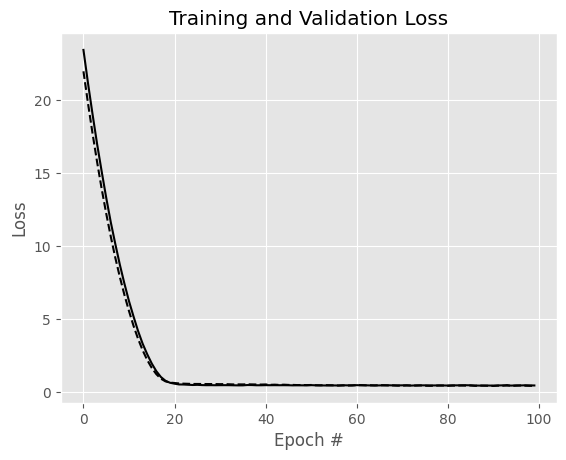

In [47]:
# plot the training and validation loss

import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.plot(np.arange(0, 100), hist.history["loss"], label="train_loss", color='black' )
plt.plot(np.arange(0, 100), hist.history["val_loss"], label="val_loss", color='black', linestyle='--')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.ylabel

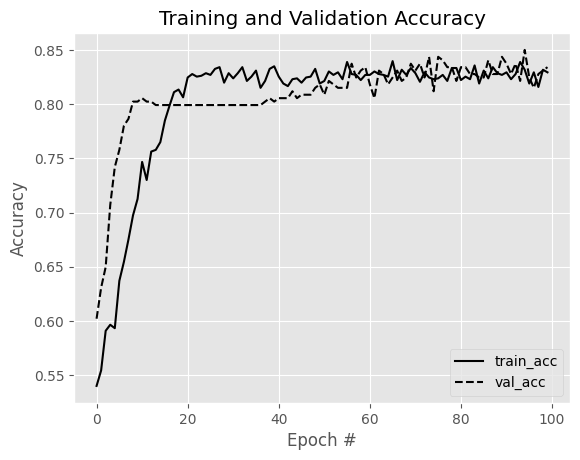

In [48]:
# plot the training and validation accuracy

plt.style.use('ggplot')
plt.plot(np.arange(0, 100), hist.history["accuracy"], label="train_acc", color='black')
plt.plot(np.arange(0, 100), hist.history["val_accuracy"], label="val_acc", color='black', linestyle='--')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Alright, we see that we have addressed the over-fitting issue.

So do experiment with the hyper-parameters or changing the model architecture to see if you can increase the accuracy of the model, while keeping a check on over-fitting as well.